In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 6 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--dragon-plus-query-encoder_7170.pkl'

In [3]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [13]:
df = df_raw.copy()
df = df[df["head_entity_names"].str.len() > 1]
print(len(df))

df["head_entity_shortest_name"] = df["head_entity_names"].apply(lambda x: min(x, key=len))
df["query_long_name"] = df["query"]
df["query_short_name"] = df.apply(lambda r: r["query"].replace(r["head_entity_longest_name"], r["head_entity_shortest_name"]), axis=1)

def replace_heads(r, replacement):
    sents = r["sents"]
    head_all_pos = []
    head_start_pos = []
    for e in r["head_entity"]:
        if "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", "") != e["name"].replace(" ", ""):
            print("ERROR", e["name"].replace(" ", ""), " != ", "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", ""))
        head_start_pos.append((e["sent_id"], e["pos"][0]))
        for i in range(e["pos"][0], e["pos"][1]):
            head_all_pos.append((e["sent_id"], i))
        
    new_words = []
    for sent_id, sent in enumerate(sents):
        for wi, word in enumerate(sent):
            if (sent_id, wi) in head_start_pos:
                new_words.append(replacement)
            if (sent_id, wi) not in head_all_pos:
                new_words.append(word)
    return " ".join(new_words)
            

df["gold_doc_long_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_longest_name"]), axis=1)
df["gold_doc_short_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_shortest_name"]), axis=1)

df[["query", "query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]].sample(5)

1878
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR G.bipinnatifida  !=  G. bipinnatifida
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR G.bipinnatifida  !=  G. bipinnatifida


,query,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name
6814,When did Peadar Bracken die?,When did Peadar Bracken die?,When did Bracken die?,"Peadar Bracken ( 23 January 1887 – January 19 , 1961 ) was an Irish freedom fighter during Ireland 's War of Independence . In 1914 he was elected Captain by the men of the Tullamore Company Irish Volunteers , before later being appointed Commandant of...","Bracken ( 23 January 1887 – January 19 , 1961 ) was an Irish freedom fighter during Ireland 's War of Independence . In 1914 he was elected Captain by the men of the Tullamore Company Irish Volunteers , before later being appointed Commandant of the At..."
178,When was The Time Of The Doves published?,When was The Time Of The Doves published?,When was Diamond Square published?,"The Time Of The Doves ( also translated as The Time Of The Doves or The Time Of The Doves ; original Catalan - language : The Time Of The Doves , that is The Time Of The Doves ) is a 1962 novel written by exiled Catalan writer Mercè Rodoreda . It is no...","Diamond Square ( also translated as Diamond Square or Diamond Square ; original Catalan - language : Diamond Square , that is Diamond Square ) is a 1962 novel written by exiled Catalan writer Mercè Rodoreda . It is notable for its use of stream of cons..."
6716,Who directed Subramaniapuram?,Who directed Subramaniapuram?,Who directed Prem Adda?,"Subramaniapuram is a 2008 Tamil - language period drama film produced , written , and directed by M. Sasikumar . The low - budget film received critical acclaim for its original script , expert direction , screenplay , editing , accurate sets and costu...","Prem Adda is a 2008 Tamil - language period drama film produced , written , and directed by M. Sasikumar . The low - budget film received critical acclaim for its original script , expert direction , screenplay , editing , accurate sets and costumes to..."
4316,What was João Paulo de Leiria e Silva a participant of?,What was João Paulo de Leiria e Silva a participant of?,What was De Silva a participant of?,"João Paulo de Leiria e Silva ( born 13 November 1964 in Luanda ) is an Angolan sport shooter . He became the only sport shooter to represent Angola at the 2000 Summer Olympics , and the second from his country to do so in Olympic history ( the first be...","De Silva ( born 13 November 1964 in Luanda ) is an Angolan sport shooter . He became the only sport shooter to represent Angola at the 2000 Summer Olympics , and the second from his country to do so in Olympic history ( the first being done by Paulo Mo..."
3049,Which country is Dollar General Corporation associated with?,Which country is Dollar General Corporation associated with?,Which country is Dollar General associated with?,"Dollar General Corporation is an American chain of variety stores headquartered in Goodlettsville , Tennessee . As of July 2018 , Dollar General Corporation operates 15,000 stores in 45 of the 48 contiguous United States ( the exceptions being three st...","Dollar General is an American chain of variety stores headquartered in Goodlettsville , Tennessee . As of July 2018 , Dollar General operates 15,000 stores in 45 of the 48 contiguous United States ( the exceptions being three states in the northwest : ..."


In [5]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

  0%|          | 0/6 [00:00<?, ?it/s]

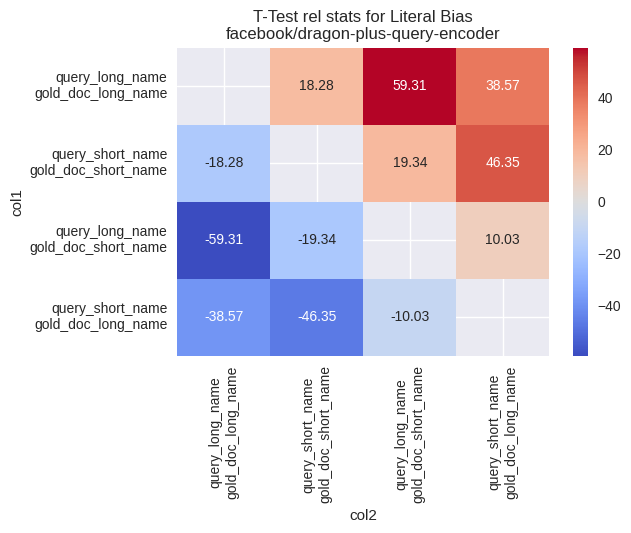

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


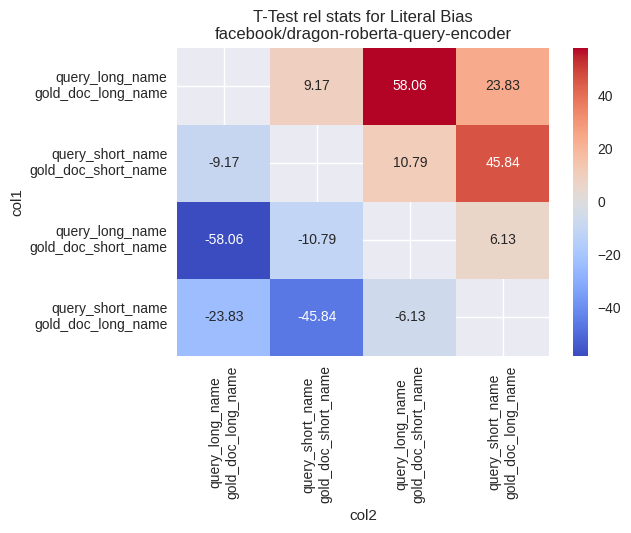

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


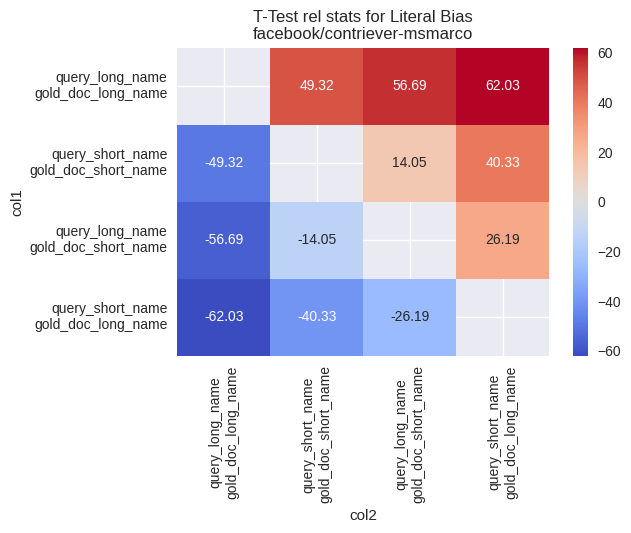

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


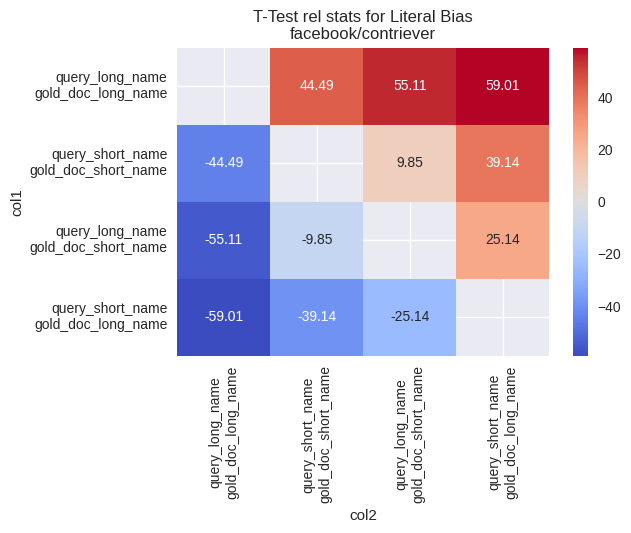

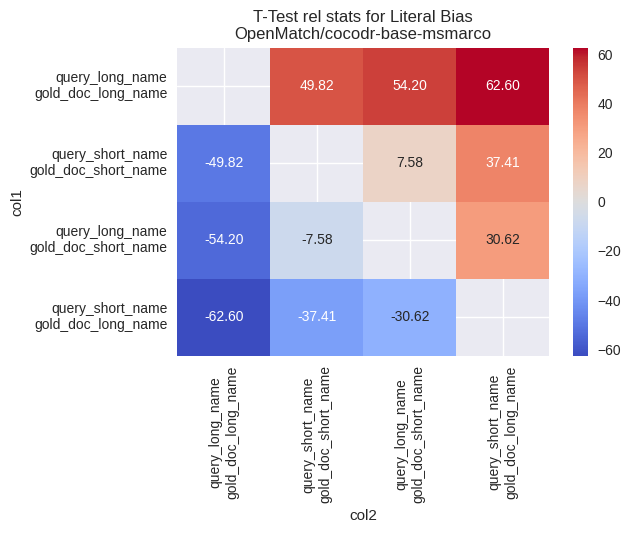

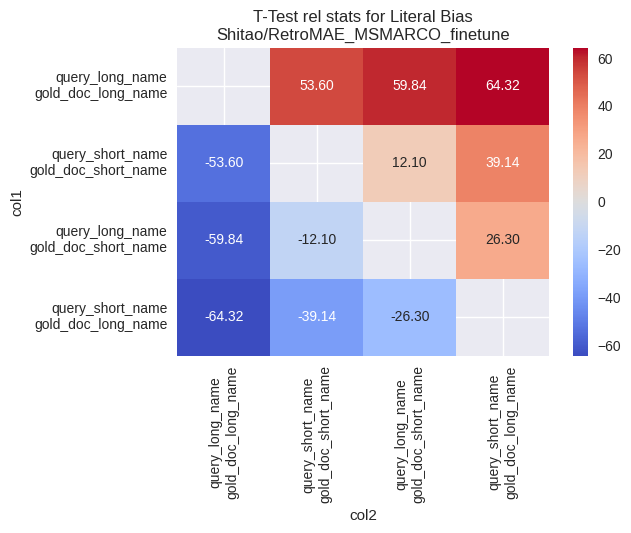

,query_model,col1,col2,ttest_stats,ttest_pvalue
0,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,NaN,NaN
1,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_long_name,38.565206,3.987078e-240
2,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_short_name,59.308893,0.000000e+00
3,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,18.282837,7.507628e-69
4,facebook/dragon-plus-query-encoder,query_short_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,-38.565206,3.987078e-240
...,...,...,...,...,...
11,Shitao/RetroMAE_MSMARCO_finetune,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_short_name,-12.098588,1.682326e-32
12,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_long_name,-53.602779,0.000000e+00
13,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name,39.137673,1.751259e-245
14,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,12.098588,1.682326e-32


In [6]:
cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]
query_cols = [
    # "query", 
    "query_long_name", "query_short_name"
]
doc_cols = [
    # "gold_doc_text", 
    "gold_doc_long_name", "gold_doc_short_name"
]

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    plot_col_dots = []
    
    for d_col in doc_cols:
        embds = dpr.encode_corpus(to_doc_format(df[d_col].to_list()))
        for q_col in query_cols:
            query_embds = dpr.encode_queries(df[q_col].to_list())
            embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds))
            new_col = f"{q_col}\n{d_col}"
            # print(new_col)
            df[new_col] = embds_dot.cpu().numpy()
            plot_col_dots.append(new_col)
    
    # df[plot_col_dots[::-1]].boxplot(figsize=(9, 5), rot=0, vert=False)
    # plt.title(f"{query_model}, support: {len(df)}")
    # plt.show()
    
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            rdf.append({
                "query_model": query_model,
                "col1": col1,
                "col2": col2,
                "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
            })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf])
    rdfp = rdf.pivot(index="col1", columns="col2", values="ttest_stats")
    order = [
        'query_long_name\ngold_doc_long_name', 
        'query_short_name\ngold_doc_short_name', 
        'query_long_name\ngold_doc_short_name',
        'query_short_name\ngold_doc_long_name',
    ]
    rdfp = rdfp.reindex(columns=order, level='col2')  # Sort columns
    rdfp = rdfp.reindex(order)
    plt.figure(figsize=(6, 4))
    sns.heatmap(rdfp, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"T-Test rel stats for Literal Bias\n{query_model}")
    plt.show()
    rdf
    

# results.append({
#     "query_model": query_model,
#     "context_model": context_model,
#     "POOLING": POOLING,
#     "support": len(df),
#     "query_type": q,
#     "sents_complete_w_end_dot_vs_wo": stats.ttest_rel(df["sents_complete_w_end_dot"], df["sents_complete_wo_end_dot"]),
#     "head_w_tail_dot_vs_wo": stats.ttest_rel(df["head_w_tail_dot"], df["head_wo_tail_dot"]),
#     "sents_complete_rm_wo_dot_vs_w": stats.ttest_rel(df["sents_complete_rm_head_wo_tail_dot"], df["sents_complete_rm_head_w_tail_dot"]),
# })
results_df

In [7]:
df = results_df.dropna().copy()

# df["col"] = df["col1"] + " vs " + df["col2"]

df["Query Name 1"] = df["col1"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 1"] = df["col1"].apply(lambda x: x.split("\n")[1].split("_")[2])
df["Query Name 2"] = df["col2"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 2"] = df["col2"].apply(lambda x: x.split("\n")[1].split("_")[2])
df = df[["query_model", "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2", "ttest_stats", "ttest_pvalue"]]
df = df[df["Query Name 1"] == df["Doc Name 1"]]
df = df[~((df["Query Name 2"] == "long") & (df["Doc Name 2"] == "long"))]
df = pd.pivot_table(
    df,
    values=[
        "ttest_stats", 
        # "ttest_pvalue",
    ],
    index=[
        "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2"
    ],
    columns=['query_model'], margins=False, aggfunc=lambda x: x.iloc[0] if len(x) == 1 else -100,
)

# LATEX
def clean_table(table_str):
    mappings = {
        "attention": "Attention",
    }
    model_mappings = {
        "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
        r"Shitao/RetroMAE\_MSMARCO\_finetune": ("RetroMAE", "MSMARCO FT"),
        r"Shitao/RetroMAE\_MSMARCO": ("RetroMAE", "MSMARCO"),
        "Shitao/RetroMAE": ("RetroMAE", ""),
        "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
        "facebook/contriever": ("Contriever", ""),
        "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
        "facebook/dragon-roberta-query-encoder": ("Dragon", "RoBERTa"),
    }
    back = "\\"
    raw_mappings = {
        # r"Method & Selection &  &  &  &  &  &  &  &  &  &  \\": "",
        r"query\_model": "Model",
        "llllrrrrrr": r"p{1.2cm}p{1.2cm}p{1.2cm}p{1.2cm}rrrrrr",
        r"\cline{1-10} \cline{2-10} \cline{3-10}": "\\midrule",
    }
    for k, v in mappings.items():
        key = k.replace('_', '\\_')
        table_str = table_str.replace("\\textbf{" + key + "}", "\\textsc{" + v + "}")
    for k, v in model_mappings.items():
        key = k
        value = r"\makecell{" + v[0] + r" \\ " + v[1] + r"}"
        table_str = table_str.replace(key, value)
    for k, v in raw_mappings.items():
        table_str = table_str.replace(k, v)
    return table_str
print(clean_table(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", r"\_")))
# print(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", "\_"))

df

\begin{tabular}{p{1.2cm}p{1.2cm}p{1.2cm}p{1.2cm}rrrrrr}
\toprule
 &  &  &  & \multicolumn{6}{r}{ttest\_stats} \\
 &  &  & Model & \makecell{COCO-DR \\ Base MSMARCO} & \makecell{RetroMAE \\ MSMARCO FT} & \makecell{Contriever \\ } & \makecell{Contriever \\ MSMARCO} & \makecell{Dragon+ \\ } & \makecell{Dragon \\ RoBERTa} \\
Query Name 1 & Doc Name 1 & Query Name 2 & Doc Name 2 &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{long}} & \multirow[t]{3}{*}{\textbf{long}} & \textbf{long} & \textbf{short} & 54.20 & 59.84 & 55.11 & 56.69 & 59.31 & 58.06 \\
\cline{3-10}
\textbf{} & \textbf{} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & 62.60 & 64.32 & 59.01 & 62.03 & 38.57 & 23.83 \\
\textbf{} & \textbf{} & \textbf{} & \textbf{short} & 49.82 & 53.60 & 44.49 & 49.32 & 18.28 & 9.17 \\
\midrule
\multirow[t]{2}{*}{\textbf{short}} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & \textbf{short} & 7.58 & 12.10 & 9.85 & 14.05 & 19.34 & 10.79 \\
\cline{3-10}
\textbf{} & \textbf{} &

ttest_stats  \
query_model                                     OpenMatch/cocodr-base-msmarco   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                 
long         long       long         short                          54.199060   
                        short        long                           62.604693   
                                     short                          49.819793   
short        short      long         short                           7.582898   
                        short        long                           37.414685   

                                                                                  \
query_model                                     Shitao/RetroMAE_MSMARCO_finetune   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                    
long         long       long         short                             59.838337   
                        short        long                              64.323062   
                                     short                             53.602779   
short        short      long         short                             12.098588   
                        short        long                              39.137673   

                                                                     \
query_model                                     facebook/contriever   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                       
long         long       long         short                55.106912   
                        short        long                 59.007515   
                                     short                44.486530   
short        short      long         short                 9.849822   
                        short        long                 39.141546   

                                                                             \
query_model                                     facebook/contriever-msmarco   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                               
long         long       long         short                        56.688042   
                        short        long                         62.027928   
                                     short                        49.318259   
short        short      long         short                        14.049207   
                        short        long                         40.327075   

                                                                                    \
query_model                                     facebook/dragon-plus-query-encoder   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                      
long         long       long         short                               59.308893   
                        short        long                                38.565206   
                                     short                               18.282837   
short        short      long         short                               19.339210   
                        short        long                                46.354682   

                                                                                       
query_model                                     facebook/dragon-roberta-query-encoder  
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                        
long         long       long         short                                  58.064234  
                        short        long                                   23.833844  
                                     short                                   9.166796  
short        short      long         short                                  10.787086  
                        short        long                                   45.844972

In [8]:
order = [
    'query_long_name\ngold_doc_long_name', 
    'query_short_name\ngold_doc_short_name', 
    'query_long_name\ngold_doc_short_name',
    'query_short_name\ngold_doc_long_name',
]
rdfp2 = rdfp.reindex(columns=order, level='col2')  # Sort columns
rdfp2 = rdfp2.reindex(order)
rdfp2

col2,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name
col1,,,,
query_long_name\ngold_doc_long_name,NaN,53.602779,59.838337,64.323062
query_short_name\ngold_doc_short_name,-53.602779,NaN,12.098588,39.137673
query_long_name\ngold_doc_short_name,-59.838337,-12.098588,NaN,26.296132
query_short_name\ngold_doc_long_name,-64.323062,-39.137673,-26.296132,NaN


# Ttest Binary

In [11]:
df = df_raw.copy()
sents_cols = [("query_short_name", "gold_doc_short_name"), ("query_short_name", "gold_doc_long_name"),]

In [14]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    for query_col, sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        query_embds = dpr.encode_queries(df[query_col].to_list())
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{query_col}{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
df_dot.head(1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,head_entity_shortest_name,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'

['facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot', 'facebook/contriever_query_short_namegold_doc_short_name_dot', 'facebook/contriever_query_short_namegold_doc_long_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,37.414685,2.181176e-229,1.645666,1.645666
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot,39.137673,1.751259e-245,1.645666,1.645666
0,Contriever,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,39.141546,1.610917e-245,1.645666,1.645666
0,Contriever MSMARCO,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,40.327075,1.227200e-256,1.645666,1.645666
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,45.844972,1.535825e-308,1.645666,1.645666
0,Dragon+,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,46.354682,2.500975e-313,1.645666,1.645666


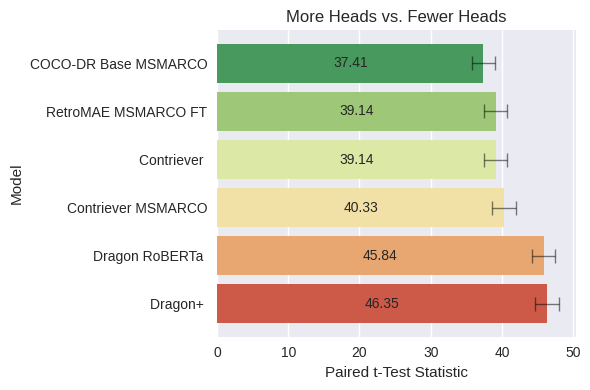

In [19]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_query")[0] and query_model == col2.split("_query")[0] and col1 != col2 and "query_short_namegold_doc_short" in col1:
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title("More Heads vs. Fewer Heads")
ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
results_df.to_json("results/literal_df.json", orient="records")
# ax.bar_label(ax.containers[0], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')
# ax.bar_label(ax.containers[1], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')

plt.tight_layout()
plt.savefig("figs/literal_ttest.pdf")
results_df